2024-10-09 19:18:04.816199: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2443 - val_loss: 0.0863
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0727 - val_loss: 0.0301
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - val_loss: 0.0045
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 - val_loss: 0.0034
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 8.0660e-04
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 8.9710e-04
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 8.0785e-04
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 5.7640e-04
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

/var/folders/63/gfgyqz0s19d0np85bch0z7k00000gn/T/ipykernel_4775/2075803941.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optimal_conditions['Time'] = pd.to_datetime(optimal_conditions['Timestamp'], unit='s').dt.strftime('%H:%M:%S')


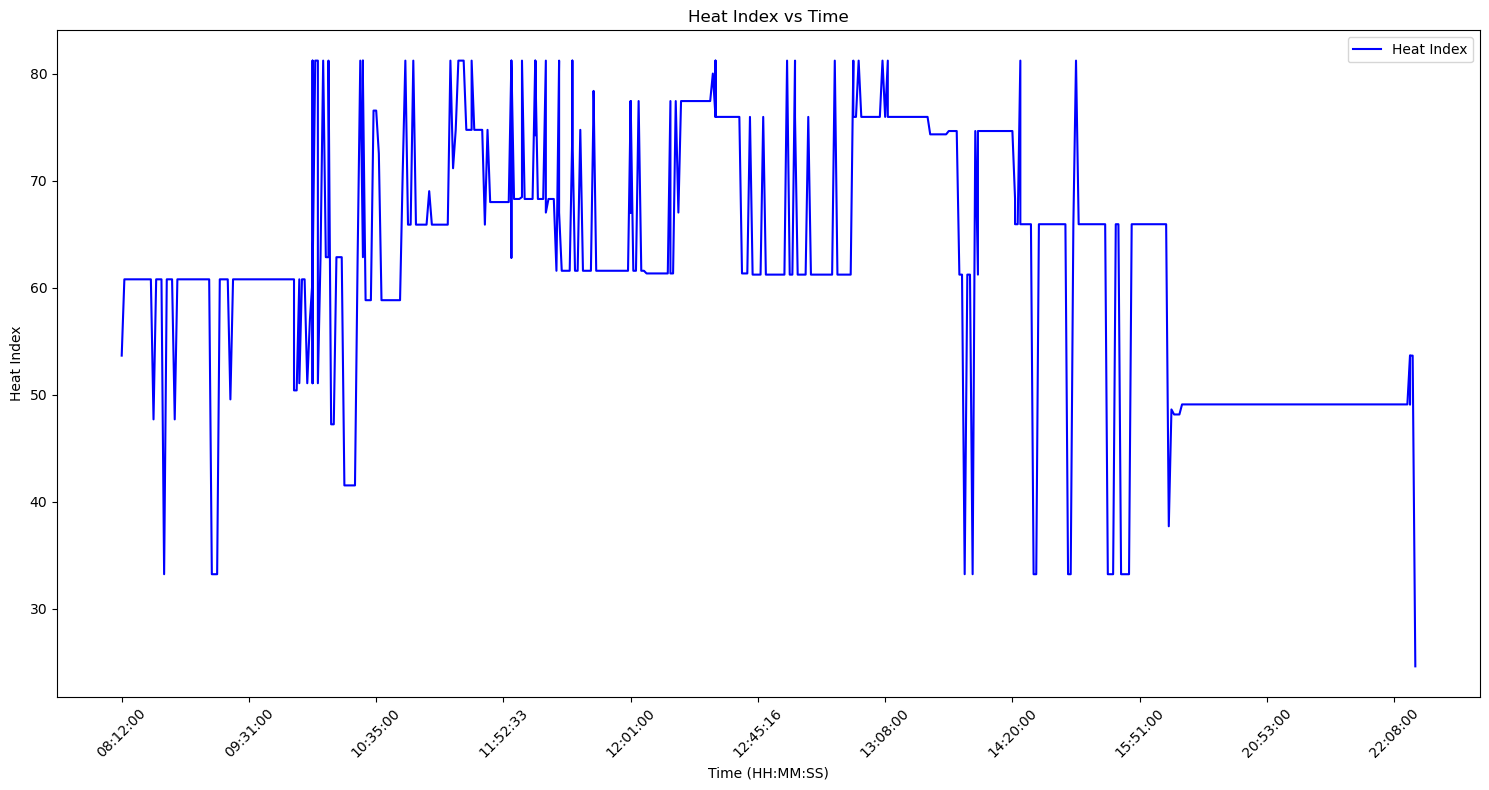

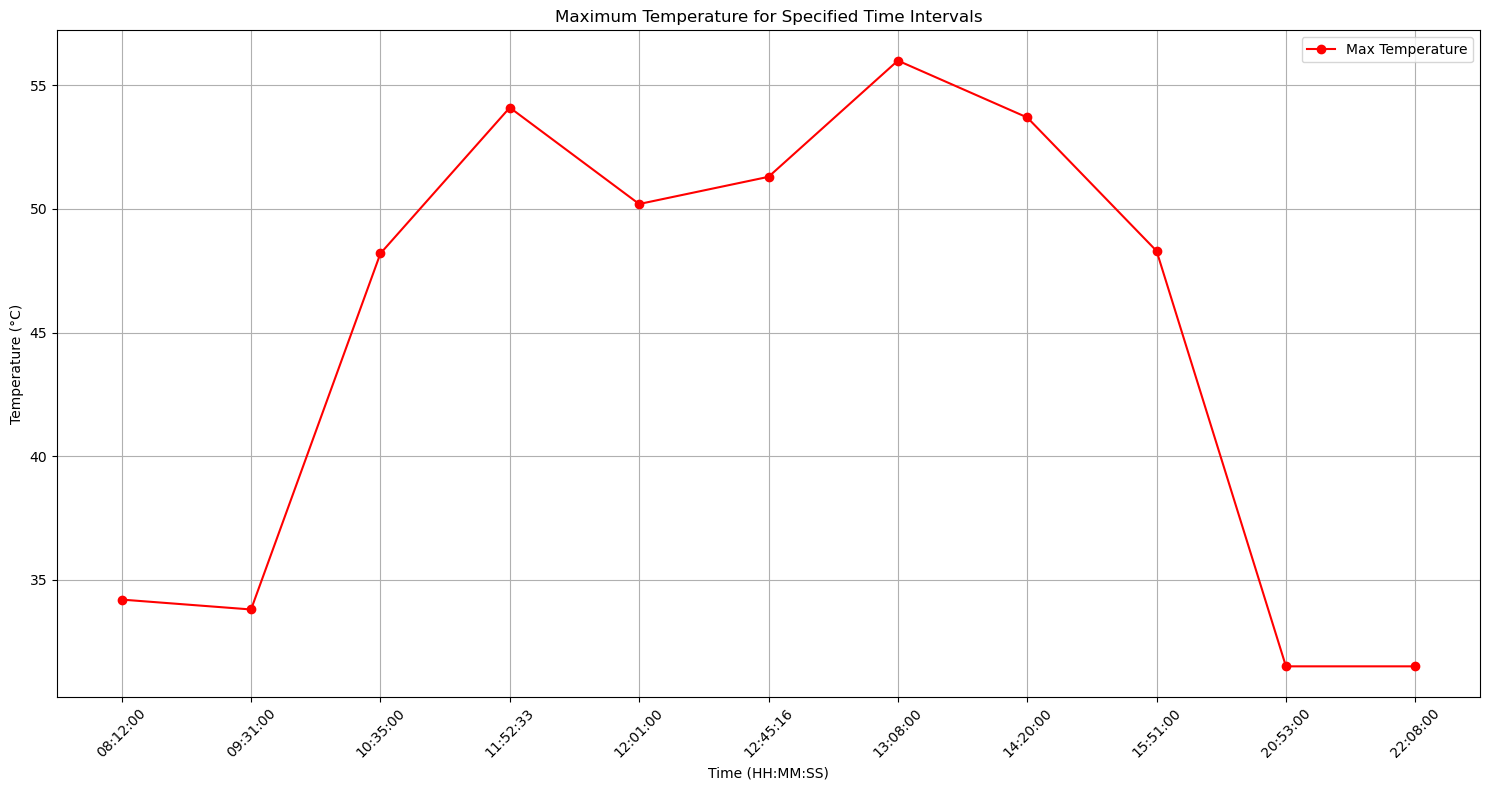

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load data
data = pd.read_csv('Temp.csv')

# Convert 'DateTime' to datetime format and then to numeric (timestamp)
data['DateTime'] = pd.to_datetime(data['DateTime'], format='mixed', errors='coerce')
data = data.dropna(subset=['DateTime'])  # Drop rows with invalid datetime entries
data['Timestamp'] = data['DateTime'].astype(np.int64) // 10**9  # Preserve timestamp for LSTM

# Convert 'Location' and 'AirQualityLevel' to numeric values
label_encoder_location = LabelEncoder()
data['Location'] = label_encoder_location.fit_transform(data['Location'])
label_encoder_aql = LabelEncoder()
data['AirQualityLevel'] = label_encoder_aql.fit_transform(data['AirQualityLevel'])

# Clean 'Temperature' and 'Humidity'
data['Temperature'] = data['Temperature'].str.replace('C', '').astype(float)
data['Humidity'] = data['Humidity'].str.replace('%', '').astype(float)

# Clean other columns
columns_to_clean = ['HeatIndex', 'CO', 'CO2', 'Ethanol', 'NH4', 'Toluene', 'Acetone', 'DustDensity']
for col in columns_to_clean:
    if col in data.columns:
        data[col] = data[col].replace(r'[^\d.]+', '', regex=True).astype(float)

# Handle missing or infinite values
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Assign HeatIndex values for the time interval 11:52:00 to 11:52:59
data['Time'] = pd.to_datetime(data['Timestamp'], unit='s').dt.strftime('%H:%M:%S')
data.loc[(data['Time'] >= '11:52:00') & (data['Time'] < '11:53:00'), 'HeatIndex'] = 68

# Define features
features = ['Timestamp', 'Location', 'Longitude', 'Lattitude', 'AirQualityLevel', 
            'Temperature', 'Humidity', 'HeatIndex', 'CO', 'CO2', 
            'Ethanol', 'NH4', 'Toluene', 'Acetone', 'DustDensity']

target = 'Temperature'  # Set temperature as the target variable

X = data[features].values
y = data[target].values.reshape(-1, 1)  # Target to predict

# Apply MinMaxScaler
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# Reshape data into LSTM format
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()

# Adding LSTM layers and Dropout to avoid overfitting
model.add(LSTM(64, return_sequences=False, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Dense layers for prediction
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Single output for the 'Temperature' target

# Compile the model with 'adam' optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model on test data
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to get original scale
predictions_rescaled = scaler_y.inverse_transform(predictions)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Calculate MSE
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
print(f"Test MSE: {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse}")

# ----------------------------------------------------------------------
# Finding Optimal Conditions for Brick Production
# ----------------------------------------------------------------------

# Define optimal criteria (e.g., high temperature, good air quality, high heat index)
threshold_temp = data['Temperature'].quantile(0.75)
threshold_airquality = data['AirQualityLevel'].quantile(0.75)
threshold_heatindex = data['HeatIndex'].quantile(0.75)

# Filter the rows based on the threshold values
optimal_conditions = data[(data['Temperature'] >= threshold_temp) & 
                          (data['AirQualityLevel'] >= threshold_airquality) &
                          (data['HeatIndex'] >= threshold_heatindex)]

# Extract 'Time' in Hour:Minute:Second format
optimal_conditions['Time'] = pd.to_datetime(optimal_conditions['Timestamp'], unit='s').dt.strftime('%H:%M:%S')

# Get all unique combinations of time, temperature, and heat index
unique_optimal_conditions = optimal_conditions.drop_duplicates(subset=['Temperature', 'HeatIndex'])

# Display all optimal situations
if unique_optimal_conditions.empty:
    print("No optimal conditions found.")
else:
    print("\nAll Unique Optimal Situations for Brick Production:")
    for i, row in unique_optimal_conditions.iterrows():
        print(f"Time: {row['Time']}, Temperature: {row['Temperature']}C, Heat Index: {row['HeatIndex']}")

# ----------------------------------------------------------------------
# Plot Heat Index vs Time
# ----------------------------------------------------------------------

# Extract 'Time' in Hour:Minute:Second format
data['Time'] = pd.to_datetime(data['Timestamp'], unit='s').dt.strftime('%H:%M:%S')

# Sort the data by 'Time' only (ignoring the date)
data_sorted = data.sort_values(by='Time')

# Plot Heat Index vs Time with properly sorted time values
plt.figure(figsize=(15, 8))

# Plot the Heat Index against the sorted Time column
plt.plot(data_sorted['Time'], data_sorted['HeatIndex'], label='Heat Index', color='blue')

plt.xlabel('Time (HH:MM:SS)')
plt.ylabel('Heat Index')
plt.title('Heat Index vs Time')

# Limit the number of xticks to reduce overcrowding by using unique times at regular intervals
unique_times_sorted = data_sorted['Time'].unique()
plt.xticks(ticks=range(0, len(unique_times_sorted), max(1, len(unique_times_sorted) // 10)), 
           labels=unique_times_sorted[::max(1, len(unique_times_sorted) // 10)], rotation=45)

plt.tight_layout()
plt.legend()
plt.show() 

# -----------------------------------------------
# Additional Data Plotting (if needed)
# -----------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('Temp.csv')

# Convert 'DateTime' to datetime format and then to numeric (timestamp)
data['DateTime'] = pd.to_datetime(data['DateTime'], format='mixed', errors='coerce')
data = data.dropna(subset=['DateTime'])  # Drop rows with invalid datetime entries
data['Timestamp'] = data['DateTime'].astype(np.int64) // 10**9  # Preserve timestamp for LSTM
# Clean 'Temperature'
data['Temperature'] = data['Temperature'].str.replace('C', '').astype(float)
# Extract 'Time' in HH:MM:SS format
data['Time'] = data['DateTime'].dt.strftime('%H:%M:%S')
# Define the specific time intervals to filter
time_intervals = [
    '08:12:00', '09:31:00', '10:35:00', 
    '11:52:33', '12:01:00', '12:45:16', 
    '13:08:00', '14:20:00', '15:51:00', 
    '20:53:00', '22:08:00'
]
# Filter the data to include only the specified time intervals
filtered_data = data[data['Time'].isin(time_intervals)]
# Group by 'Time' and take the maximum temperature for each interval
max_temp_per_time = filtered_data.groupby('Time')['Temperature'].max().reset_index()
# Plotting the unique maximum temperatures for the specified time intervals
plt.figure(figsize=(15, 8))
plt.plot(max_temp_per_time['Time'], max_temp_per_time['Temperature'], label='Max Temperature', color='red', marker='o')
plt.title('Maximum Temperature for Specified Time Intervals')
plt.xlabel('Time (HH:MM:SS)')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()
